# Exercise 3
All previous instructions hold. In addition, if you are using GPU, you must check that your code also runs on a CPU. 

**Make sure you use the best practices you learned in class**.

In this exercise, you will accomplish the following:
1. Train a convolutional network using PyTorch and evaluate it.
2. Visualize a neural network layer and interpet thier meaning.

In [1]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from PIL import Image
import torchvision.transforms as T
from scipy.ndimage.filters import gaussian_filter1d
from torch.autograd import Variable

SQUEEZENET_MEAN = np.array([0.485, 0.456, 0.406], dtype=np.float32)
SQUEEZENET_STD = np.array([0.229, 0.224, 0.225], dtype=np.float32)

%matplotlib inline
plt.rcParams['figure.figsize'] = (12.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device is {device}")

Device is cuda


# Convolutional Neural Network - Classifiying CIFAR-10 (60 points)

So far we had to manually implement both the forward and backward passes of our neural network. Manually implementing the backward pass is not a big deal for a small two-layer network, but can quickly get very messy for large complex networks.

Thankfully, we can use **automatic differentiation** to automate the computation of backward passes in neural networks. The autograd package in PyTorch provides exactly this functionality. When using autograd, the forward pass of your network will define a computational graph. Nodes in the graph will be Tensors,
and edges will be functions that produce output Tensors from input Tensors. Backpropagating through this graph then allows you to easily compute gradients.

If we want to compute gradients with respect to some Tensor, then we set `requires_grad=True` when constructing that Tensor. Any PyTorch operations on that Tensor will cause a computational graph to be constructed, allowing us to later perform backpropagation through the graph. If `x` is a Tensor with `requires_grad=True`, then after backpropagation `x.grad` will be another Tensor holding the gradient of `x`.

Sometimes you may wish to prevent PyTorch from building computational graphs when performing certain operations on Tensors with `requires_grad=True`; for example, we usually don't want to backpropagate through the weight update steps when evaluating a neural network. In such scenarios we can use the `torch.no_grad()` context manager to prevent the construction of a computational graph.


## Data Preprocessing

In [3]:
transform = T.Compose(
    [T.ToTensor(),
     T.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Image shape:  torch.Size([3, 32, 32])
     truck        cat       ship      plane


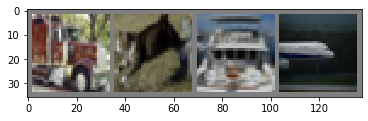

In [4]:
# functions to show an image
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0))) # plt accepts images in the format (w,h,c)
    
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

print("Image shape: ", images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images[:4]))
# print labels
print(' '.join('%10s' % classes[labels[j]] for j in range(4)))

## Construct a CNN in PyTorch - 30 points

In the following class, initiate your different layers in the `__init__` method and define your architecture in the `forward` method. Make sure the `forward` method has a single return value. 

1. Make good use of the documentation and experiment will different layers, activations and architectures, batch sizes, regularization, filter sizes, dimensions, number of layers and whatever you learned in class. 
1. Use your intuition from the previous exercises and additional sources such as the Piazza, papers, etc. - do not try to perform a massive grid search.
1. **Your model must end with two linear layers. (with activations between them)**.
1. **Include only your chosen architecture**. During experimentation, you may add as many cells as you need. Make sure to delete them before submission.
1. Make sure your code runs reasonably fast (~30 minutes on CPU and ~5 minutes on GPU).
1. Use the best architecture you find and train it for 5-10 epochs. 
1. Explain why you chose that architecture and why you think it performs better than other networks you tried. Cite papers, blogs, MOOCs, online guides and every other source you used during optimization.
1. Visualize the loss and accuracy of your network during training. You can use matplotlib or seaborn.
1. **You should get close to 75% accuracy, explain you results and include visualizations for the full 30 points**.

In [5]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #############################################################################
        # TO DO:                                                                    #
        # Initiate the different layers you wish to use in your network.            #
        # This method has no return value.                                          #
        #############################################################################
        self.feature_extractor_seq = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1), # input: 32 x 32 x 3 -> output: 32 x 32 x 32
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1), #input: 32 X 32 X 32 -> output 32 x 32 x 64
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # input: 32 X 32 X 64 -> output: 16 x 16 x 64

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # input: 16 X 16 X 128 -> output: 8 x 8 x 128 

            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1), # input: 8 X 8 X 128 -> output: 8 x 8 x 256
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(2, 2), # input: 8 X 8 X 256 -> output: 4 x 4 x 256 
        )
        self.linearSeq = nn.Sequential(
            nn.Flatten(), # input: 4 x 4 x 256 -> output: 1 x 4096 
            nn.Dropout2d(),
            nn.Linear(256*4*4, 1024), # input: 1 x 4096 -> output: 1 x 1024 
        )
        self.lastLinearLayer = nn.Sequential(
            nn.Dropout2d(),
            nn.Linear(1024, 10) # input: 1 x 512 -> output: 1 x 10 
        )
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

    def feature_extraction(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Pass through the image x thghrough all layers except the last one         #
        # and the activation between it and the previous linear layer.              #
        # This way we can extract the feature space that the network generetes      #
        # before the final prediction.                                              #
        #############################################################################
        x = self.feature_extractor_seq(x)
        x = self.linearSeq(x)
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################
        
    def forward(self, x):
        #############################################################################
        # TO DO:                                                                    #
        # Define the forward propagation. You need to pass an image through the     #
        # network and obtain class predictions.                                     #
        # This function returns the predication of your model.                      #
        #############################################################################
        x = self.feature_extractor_seq(x)
        x = self.linearSeq(x)
        x = self.lastLinearLayer(x)
        return x
        #############################################################################
        #                             END OF YOUR CODE                              #
        #############################################################################

net = Net().to(device)
criterion = None
optimizer = None
#############################################################################
# TO DO:                                                                    #
# Define the loss function and optimizer.                                   #
# You are encouraged to experiment with different optimizers                #
#############################################################################

criterion = nn.CrossEntropyLoss()  # Loss function goes here
optimizer = optim.Adam(net.parameters()) # optimizer goes here

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [6]:
#############################################################################
# TO DO:                                                                    #
# Define the training loop as seen in class and as demonstrated in the      #
# documentation. Note, if you are using GPU, make sure your code runs on    #
# CPU also. Code that cannot run will not be tested.                        # 
#############################################################################

def train_network(net, criterion, optimizer, trainloader,num_epochs):
    print("Let's Start Training our net!")
    for epoch in range(num_epochs): 
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            # get the inputs
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # zero the parameter gradients
            optimizer.zero_grad()
            # forward + backard + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  
            optimizer.step()
            # print statistics
            running_loss += loss.item()
        print('epoch: [%d] loss: %.3f' %(epoch + 1, running_loss / 2000))
        running_loss = 0.0
    print('Finished Training')
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

In [7]:
num_epochs = 7
train_network(net, criterion, optimizer, trainloader,num_epochs)

Let's Start Training our net!
epoch: [1] loss: 0.712
epoch: [2] loss: 0.411
epoch: [3] loss: 0.330
epoch: [4] loss: 0.285
epoch: [5] loss: 0.255
epoch: [6] loss: 0.231
epoch: [7] loss: 0.207
Finished Training


In [8]:
def calc_net_accuracy(net, testloader):
    with torch.no_grad():
        correct = 0
        total = 0
        for data in testloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    print('Accuracy of the network on the 10000 test images: %d %%' % (100 * correct / total))
    
calc_net_accuracy(net, testloader)

Accuracy of the network on the 10000 test images: 77 %


GroundTruth:      cat    ship    ship   plane
Predicted:        cat    ship    ship   plane


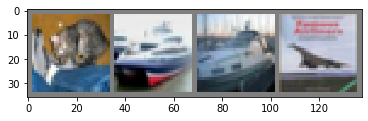

In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()
imshow(torchvision.utils.make_grid(images[:4]))
print('GroundTruth: ', ' '.join('%7s' % classes[labels[j]] for j in range(4)))
outputs = net(images.to(device))
_, predicted = torch.max(outputs, 1)
print('Predicted:   ', ' '.join('%7s' % classes[predicted[j]]for j in range(4)))


## Properties of my model:
**Filter Size:** 3x3

**Number of Filters:** 32, 64, 128, 256.

**Loss Function:** Cross - Entropy Loss.

**Pooling:** 2x2 max-pooling.

**Normalization:** Batch normalization.

**Network Architecture:** (conv - batchnorm - relu) * 1 - (conv - batchnorm - relu - max pool) * 3 - (dropout - fc) * 2.

**Flattening:** used flattening after the final convolutional layer.

**Regularization:** Dropout.

**Optimizer:** Adam.

**Every other source you used during optimization and my net building:** 
1. https://www.programcreek.com/python/example/107657/torch.nn.Dropout2d
2. https://atcold.github.io/pytorch-Deep-Learning/en/week05/05-2/
3. https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html
4. https://stackoverflow.com/questions/53290306/confusion-matrix-and-test-accuracy-for-pytorch-transfer-learning-tutorial
5. https://notebook.community/ALEXKIRNAS/DataScience/CS231n/assignment3/NetworkVisualization-PyTorch
6. https://arxiv.org/abs/1409.1556

**My main idea for my cnn came from this architecture that we saw in class:** [netArchi](https://drive.google.com/file/d/1hM_S1fjlkb58TD8sPWaD7zEOPK5GugbR/view?usp=sharing) but this net is to complex for our goal (~75% and 5 minutes on GPU) so i added few more dropouts, batch norm, and I reduced the number of layers. 
1. Pooling: Max pooling is a pooling operation that selects the maximum element from the region of the feature map covered by the filter. Thus, the output after max-pooling layer would be a feature map containing the most prominent features of the previous feature map.
2. Optimisation: Adam is an optimization algorithm that can be used instead of the classical stochastic gradient descent procedure to update network weights iterative based in training data.
3. Normalization: Batch normalization is a layer that allows every layer of the network to do learning more independently. It is used to normalize the output of the previous layers. The layer is added to the sequential model to standardize the input or the outputs. It can be used at several points in between the layers of the model.
4. Regularization: "We trained dropout neural networks for classification problems on data sets in different domains. We found that dropout improved generalization performance on all data sets compared to neural networks that did not use dropout." and yes I saw a big difference with or without dropouts. 
5. Loss function: Cross-entropy will calculate a score that summarizes the average difference between the actual and predicted probability distributions for all classes in the problem. The score is minimized and a perfect cross-entropy value is 0.

## Model Class Performance Evaluation - 15 points

1. Calculate the confusion matrix for the model. You are allowed to use loops.
1. Calculate and print the model's overall accuracy and the accuracy for each class.
1. Plot the confusion matrix with matplotlib where the y axis represents the real category and the x axis represents the predicted category and print the accuracies. (make sure the rows and columns are labeled with the proper class names).
1. **Explain the results**: what can you learn from the confusion matrix? Why do you need additional evaluation methods other than accuracy?

In [10]:
confusion_matrix = np.zeros([10,10], int)
#############################################################################
# TO DO:                                                                    #
# Define the evaluation loop as seen in class and as demonstrated in the    #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
correct_pred = {classname: 0 for classname in classes}
total_pred = {classname: 0 for classname in classes}
correct = 0
total = 0
with torch.no_grad():
  for images, labels in testloader:
    images = images.to(device)
    labels = labels.to(device)
  
    output = net(images)
    _, predicted = torch.max(output.data, 1)
  
    total += labels.size(0)
    correct += (predicted == labels).sum()

    for t, p in zip(labels.view(-1), predicted.view(-1)):
                confusion_matrix[t.long(), p.long()] += 1

    for label, prediction in zip(labels, predicted):
            if label == prediction:
                correct_pred[classes[label]] += 1
            total_pred[classes[label]] += 1
    
print('Overall accuracy: %.4f %%' % (100 * correct / total))
for classname, correct_count in correct_pred.items():
    accuracy = 100 * float(correct_count) / total_pred[classname]
    print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))

#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

Overall accuracy: 77.5500 %
Accuracy for class plane is: 76.7 %
Accuracy for class car   is: 91.7 %
Accuracy for class bird  is: 66.1 %
Accuracy for class cat   is: 64.6 %
Accuracy for class deer  is: 80.7 %
Accuracy for class dog   is: 64.1 %
Accuracy for class frog  is: 79.1 %
Accuracy for class horse is: 85.9 %
Accuracy for class ship  is: 90.0 %
Accuracy for class truck is: 76.6 %


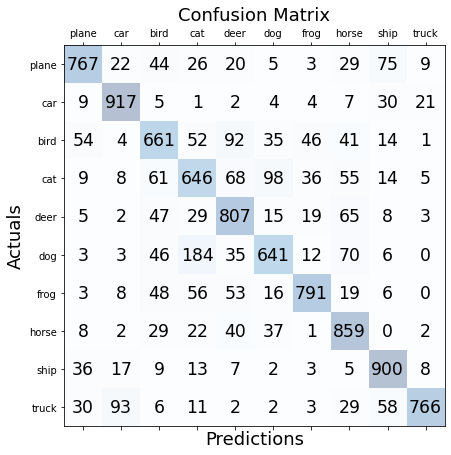

In [11]:
#############################################################################
# TO DO:                                                                    #
# plot the confusion matrix, use labels to show what is the predicted\actual#
# and label each row column with the correct class description              #
# documentation and use the confusion matrix to evaluate your model.        # 
#############################################################################
def plot_CM(cm):
  fig, ax = plt.subplots(figsize=(7, 7))
  ax.matshow(confusion_matrix, cmap=plt.cm.Blues, alpha=0.3)
  for i in range(confusion_matrix.shape[0]):
      for j in range(confusion_matrix.shape[1]):
          ax.text(x=j, y=i,s=confusion_matrix[i, j], va='center', ha='center', size='xx-large')
  ax.set(xticks=np.arange(10), yticks=np.arange(10), xticklabels=classes, yticklabels=classes)
  plt.xlabel('Predictions', fontsize=18)
  plt.ylabel('Actuals', fontsize=18)
  plt.title('Confusion Matrix', fontsize=18)
  plt.show()

plot_CM(confusion_matrix)
#############################################################################
#                             END OF YOUR CODE                              #
#############################################################################

we can see that the main diagnol is consistent with our overall accuracy for example plane has 76.7% and in our matrix we got 767. the additional data that we recived from the CM is that we can now the ratio between the time our model misclassified plane And thought it was a frog (3). we can undrestand from this matrix If the error of our model is legitimate and understandable or is it a significant error and we need to correct the parameters for example.


## Visualizing and Evaluating the Model's latent space - 15 points

In order to furether evaluate our network's model performance, we would like to visualize its feature's latent space in 2d and see which classes are close to each other. In order to accomplish this we are going to use the "T-SNE" algorithem to project our feature space to a lower dimension.

1. Set the model to evaluation mode and use the feature_extraction method to get the feature representation of the 10,000 test set images using the feature_extraction method.

2. Read the documentation of "https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html" and use T-SNE to project the images from the high dimensional feature space to the lower dimensional feature space.

3. Visualize the image distrubtion in the 2d space by plotting each image with the color of its label (total 10 labels\colors) using matplotlib scatter plot.

4. What can you learn from the plot? is it consistent with the confusion matrix?

In [12]:
torch.save(net.state_dict(), 'tensor.pt')
conv1 = Net()
conv1.load_state_dict(torch.load('tensor.pt'))

<All keys matched successfully>

In [13]:
logits_list = []  
targets = []

with torch.no_grad():
    for t_image, target in testloader:
        target = target.data.cpu().numpy()
        targets.append(target)

        logits = conv1.feature_extraction(t_image.float())

        logits = logits.data.cpu().numpy()
        logits_list.append(logits) 

concated_images = np.concatenate(logits_list, axis = 0)
concated_targets = np.concatenate(targets, axis = 0)

/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/manifold/_t_sne.py:793: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  FutureWarning,
No handles with labels found to put in legend.


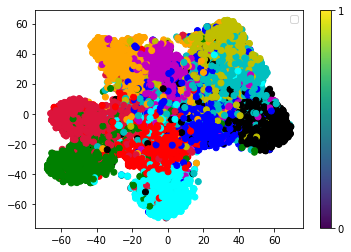

In [14]:
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, random_state=0)
X = tsne.fit_transform(concated_images)

colors = 'r', 'g', 'b', 'c', 'm', 'y', 'k', 'orange', 'cyan', 'crimson'
plt.scatter(X[:,0],X[:,1],c = [colors[x] for x in concated_targets] ,cmap=plt.cm.get_cmap("jet", 10))
plt.colorbar(ticks=range(10))
plt.legend()
plt.show()

Following the reduction of the dimension of our data to 2D, we can identify in clusters of similar data. The similar points are close to each other. Belonging to the same cluster. But we can also notice anomalies of colors that "leaked" to other clusters in which we mistakenly classified. Yes the plot is consistent eith the confusion matrix.

# Network Visualization - 40 points

In this part we are going to load a pretrained model classifier model called SqueezeNet and explore the meaning (and some would say intent) behind the calculation in its layer's.

1. **Saliency Maps**: Saliency maps are a quick way to tell which part of the image influenced the classification decision made by the network.
1. **Fooling Images**: We can perturb an input image so that it appears the same to humans, but will be misclassified by the pretrained network.



In [15]:
!wget https://raw.githubusercontent.com/Oringa/pytorch_workshop/master/imagenet_val_25.npz

--2021-12-08 18:19:55--  https://raw.githubusercontent.com/Oringa/pytorch_workshop/master/imagenet_val_25.npz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3940548 (3.8M) [application/octet-stream]
Saving to: ‘imagenet_val_25.npz.2’

imagenet_val_25.npz 100%[===================>]   3.76M  --.-KB/s    in 0.07s   

2021-12-08 18:19:55 (54.0 MB/s) - ‘imagenet_val_25.npz.2’ saved [3940548/3940548]




## Helper Functions

Our pretrained model was trained on images that had been preprocessed by subtracting the per-color mean and dividing by the per-color standard deviation. We define a few helper functions for performing and undoing this preprocessing. 

In [16]:
def preprocess(img, size=224):
    transform = T.Compose([
        T.Resize(size),
        T.ToTensor(),
        T.Normalize(mean=SQUEEZENET_MEAN.tolist(),
                    std=SQUEEZENET_STD.tolist()),
        T.Lambda(lambda x: x[None]),
    ])
    return transform(img)

def deprocess(img, should_rescale=True):
    transform = T.Compose([
        T.Lambda(lambda x: x[0]),
        T.Normalize(mean=[0, 0, 0], std=(1.0 / SQUEEZENET_STD).tolist()),
        T.Normalize(mean=(-SQUEEZENET_MEAN).tolist(), std=[1, 1, 1]),
        T.Lambda(rescale) if should_rescale else T.Lambda(lambda x: x),
        T.ToPILImage(),
    ])
    return transform(img)

def rescale(x):
    low, high = x.min(), x.max()
    x_rescaled = (x - low) / (high - low)
    return x_rescaled
    
def blur_image(X, sigma=1):
    X_np = X.cpu().clone().numpy()
    X_np = gaussian_filter1d(X_np, sigma, axis=2)
    X_np = gaussian_filter1d(X_np, sigma, axis=3)
    X.copy_(torch.Tensor(X_np).type_as(X))
    return X

## Pretrained model

For all of our image generation experiments, we will start with a convolutional neural network which was pretrained to perform image classification on ImageNet. We can use any model here, but for the purposes of this assignment we will use [SqueezeNet](https://arxiv.org/abs/1602.07360), which achieves accuracies comparable to AlexNet but with a significantly reduced parameter count and computational complexity.

Using SqueezeNet rather than AlexNet, VGG or ResNet means that we can easily perform all image generation experiments on CPU.

In [17]:
# Download and load the pretrained SqueezeNet model.
model = torchvision.models.squeezenet1_1(pretrained=True)

# We don't want to train the model, so tell PyTorch not to compute gradients
# with respect to model parameters.
for param in model.parameters():
    param.requires_grad = False

## Load some ImageNet images

We have provided a few example images from the validation set of the ImageNet ILSVRC 2012 Classification dataset. Since they come from the validation set, our pretrained model did not see these images during training.

In [18]:
import numpy as np

def load_imagenet_val(num=None):
    """Load a handful of validation images from ImageNet.
    Inputs:
    - num: Number of images to load (max of 25)
    Returns:
    - X: numpy array with shape [num, 224, 224, 3]
    - y: numpy array of integer image labels, shape [num]
    - class_names: dict mapping integer label to class name
    """
    imagenet_fn = 'imagenet_val_25.npz'
    f = np.load(imagenet_fn, allow_pickle=True)
    X = f['X']
    y = f['y']
    class_names = f['label_map'].item()
    if num is not None:
        X = X[:num]
        y = y[:num]
    return X, y, class_names

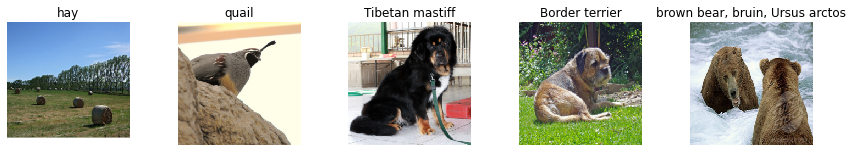

In [19]:
X, y, class_names = load_imagenet_val(num=5)

plt.figure(figsize=(12, 6))
for i in range(5):
    plt.subplot(1, 5, i + 1)
    plt.imshow(X[i])
    plt.title(class_names[y[i]])
    plt.axis('off')
plt.gcf().tight_layout()

## Saliency Maps
A saliency map tells us the degree to which each pixel in the image affects the classification score for that image. To compute it, we compute the gradient of the unnormalized score corresponding to the correct class (which is a scalar) with respect to the pixels of the image. If the image has shape (3, H, W) then this gradient will also have shape (3, H, W); for each pixel in the image, this gradient tells us the amount by which the classification score will change if the pixel changes by a small amount. To compute the saliency map, we take the absolute value of this gradient, then take the maximum value over the 3 input channels; the final saliency map thus has shape (H, W) and all entries are nonnegative.

### PyTorch gather method
If `s` is an numpy array of shape `(N, C)` and `y` is a numpy array of shape `(N,)` containing integers `0 <= y[i] < C`, then `s[np.arange(N), y]` is a numpy array of shape `(N,)` which selects one element from each element in `s` using the indices in `y`.

In PyTorch you can perform the same operation using the `gather()` method. If `s` is a PyTorch Tensor of shape `(N, C)` and `y` is a PyTorch Tensor of shape `(N,)` containing longs in the range `0 <= y[i] < C`, then `s.gather(1, y.view(-1, 1)).squeeze()` will be a PyTorch Tensor of shape `(N,)` containing one entry from each row of `s`, selected according to the indices in `y`.



In [20]:
def gather_example():
    N, C = 4, 5
    s = torch.randn(N, C)
    y = torch.LongTensor([1, 2, 1, 3])
    print(s)
    print(y)
    print(s.gather(1, y.view(-1, 1)).squeeze())
gather_example()

tensor([[ 0.4915,  1.6899, -2.7702,  0.5369, -0.0189],
        [-0.3628, -1.2660, -0.0739,  1.1792,  0.5063],
        [-0.6376, -1.4184, -0.4515,  1.0601,  1.5754],
        [-0.1857,  0.0710, -0.2912, -0.9292, -0.8712]])
tensor([1, 2, 1, 3])
tensor([ 1.6899, -0.0739, -1.4184, -0.9292])


In [23]:
def compute_saliency_maps(X, y, model):
    """
    Compute a class saliency map using the model for images X and labels y.

    Input:
    - X: Input images; Tensor of shape (N, 3, H, W)
    - y: Labels for X; LongTensor of shape (N,)
    - model: A pretrained CNN that will be used to compute the saliency map.

    Returns:
    - saliency: A Tensor of shape (N, H, W) giving the saliency maps for the input
    images.
    """
    model.eval()
    ##############################################################################
    # TODO: Implement this function. Perform a forward and backward pass through #
    # the model to compute the gradient of the correct class score with respect  #
    # to each input image. You first want to compute the loss over the correct   #
    # scores (we'll combine losses across a batch by summing), and then compute  #
    # the gradients with a backward pass.                                        #
    ##############################################################################
    X.requires_grad_()
    scores = model(X)
    labels_scores = scores.gather(1, y.view(-1, 1)).squeeze()
    loss = -torch.sum(torch.log(labels_scores))
    loss.backward()
    images_grads = X.grad.data
    abs_images_grads = images_grads.abs()
    saliency, _ = abs_images_grads.max(dim=1)
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return saliency

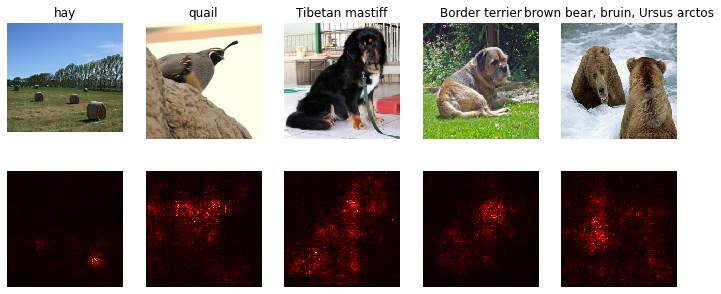

In [25]:
def show_saliency_maps(X, y):
    # Convert X and y from numpy arrays to Torch Tensors
    X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
    y_tensor = torch.LongTensor(y)

    # Compute saliency maps for images in X
    saliency = compute_saliency_maps(X_tensor, y_tensor, model)
    # Convert the saliency map from Torch Tensor to numpy array and show images
    # and saliency maps together.
    saliency = saliency.numpy()
    N = X.shape[0]
    for i in range(N):
        plt.subplot(2, N, i + 1)
        plt.imshow(X[i])
        plt.axis('off')
        plt.title(class_names[y[i]])
        plt.subplot(2, N, N + i + 1)
        plt.imshow(saliency[i], cmap=plt.cm.hot)
        plt.axis('off')
        plt.gcf().set_size_inches(12, 5)
    plt.show()

show_saliency_maps(X, y)

## Fooling classifiers

We can also use image gradients to generate "fooling images". Given an image and a target class, we can perform gradient ascent over the image to maximize the target class, stopping when the network classifies the image as the target class. Implement the following function to generate fooling images.

In [30]:
def make_fooling_image(X, target_y, model):
    """
    Generate a fooling image that is close to X, but that the model classifies
    as target_y.

    Inputs:
    - X: Input image; Tensor of shape (1, 3, 224, 224)
    - target_y: An integer in the range [0, 1000)
    - model: A pretrained CNN

    Returns:
    - X_fooling: An image that is close to X, but that is classifed as target_y
    by the model.
    """
    # Initialize our fooling image to the input image, and make it require gradient
    X_fooling = X.clone()
    X_fooling_var = X_fooling.requires_grad_()
    
    learning_rate = 1
    ##############################################################################
    # TODO: Generate a fooling image X_fooling that the model will classify as   #
    # the class target_y. You should perform gradient ascent on the score of the #
    # target class, stopping when the model is fooled.                           #
    # When computing an update step, first normalize the gradient:               #
    #   dX = learning_rate * g / ||g||_2                                         #
    #                                                                            #
    # You should write a training loop.                                          #
    #                                                                            #
    # HINT: For most examples, you should be able to generate a fooling image    #
    # in fewer than 100 iterations of gradient ascent.                           #
    # You can print your progress over iterations to check your algorithm.       #
    ##############################################################################
    while True:
        scores = model(X_fooling_var)
        max_scores, max_scores_indeces = scores.data.max(dim=1)      
        
        is_labels_correct = max_scores_indeces != target_y
        if is_labels_correct.all():
            scores[:, target_y].backward()
            img_grad = X_fooling_var.grad.data
            normilized_img_grad = torch.norm(img_grad, 2)
            with torch.no_grad():
              dX = learning_rate * img_grad / normilized_img_grad
              X_fooling += dX
            X_fooling_var.grad.data.zero_()
        else:
            break
    ##############################################################################
    #                             END OF YOUR CODE                               #
    ##############################################################################
    return X_fooling

In [31]:
idx = 2
target_y = 443

X_tensor = torch.cat([preprocess(Image.fromarray(x)) for x in X], dim=0)
X_fooling = make_fooling_image(X_tensor[idx:idx+1], target_y, model)

scores = model(X_fooling)
assert target_y == scores.data.max(1)[1][0].item(), 'The model is not fooled!'

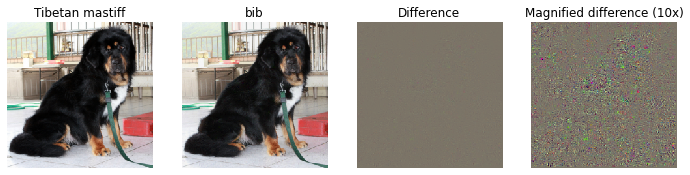

In [32]:
X_fooling_np = deprocess(X_fooling.clone())
X_fooling_np = np.asarray(X_fooling_np).astype(np.uint8)

plt.subplot(1, 4, 1)
plt.imshow(X[idx])
plt.title(class_names[y[idx]])
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(X_fooling_np)
plt.title(class_names[target_y])
plt.axis('off')

plt.subplot(1, 4, 3)
X_pre = preprocess(Image.fromarray(X[idx]))
diff = np.asarray(deprocess(X_fooling - X_pre, should_rescale=False))
plt.imshow(diff)
plt.title('Difference')
plt.axis('off')

plt.subplot(1, 4, 4)
diff = np.asarray(deprocess(10 * (X_fooling - X_pre), should_rescale=False))
plt.imshow(diff)
plt.title('Magnified difference (10x)')
plt.axis('off')

plt.gcf().set_size_inches(12, 5)
plt.show()

The End